In [92]:
import numpy as np
import matplotlib.pyplot as plt
import vector
import pandas as pd
import lhapdf
import itertools

## General code for calculating polarization vector

In [93]:
# Tau mass
mtau = 1.77682 # GeV

def polarization_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
  
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    # DUNE paper eq 10, 11, 12
    F = (
        (2*W1 + mtau**2/M**2 * W4) * (Etau - ptau * costheta) + W2 * (Etau + ptau * costheta) - W5 * mtau**2 / M
        # Only difference with tau polarization paper is that it is -W3 instead of +W3
        - W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
    )

    return (
        # P_T. Only difference with tau polarization paper is that it is -W3 instead of +W3
        -mtau * np.sin(theta) * (2*W1 - W2 - mtau**2 / M**2 * W4 + W5 * Etau / M - W3 * Enu / M) / F,
        # P_L
        -(
            (2*W1 - mtau**2/M**2 * W4) * (ptau - Etau * costheta) + W2 * (ptau + Etau * costheta) - W5 * mtau**2 / M * costheta
            # Only difference with tau polarization paper is that it is -W3 instead of +W3
            - W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
        ) / F
    )

    # R = (
    #     (Etau - ptau * costheta) / M * (W1 + mtau**2 / (2*M**2)*W4)
    #     + (Etau + ptau * costheta) / (2*M) * W2
    #     + ((Enu + Etau) / M * (Etau - ptau * costheta) / (2*M) - mtau**2 / (2*M**2)) * W3
    #     - mtau**2 / (2*M**2) * W5
    # )

    # return (
    #     # P_P component, in the tau-nu plane
    #     mtau * np.sin(theta) / (2*M*R) * (
    #         -(2*W1 - W2 - mtau**2/M**2 * W4 + Etau/M * W5) - Enu / M * W3 # X in lepton polarization paper, eq 7a
    #     ),
    #     # P_L component
    #     -1 + mtau**2/(M**2 * R) * (
    #         (2*M/(Etau + ptau) * W1 + (Etau - ptau) / (Etau + ptau) * W3) * np.cos(theta/2)**2
    #         + (M/(Etau + ptau) * W2 + (Etau + ptau) / M * W4 - W5) * np.sin(theta/2)**2
    #     ),
    # )


def spin_vector(tau4m, nu4m, nucleon4m, int_type: str, x=None, W=None, charm=None, pdfvalues: pd.DataFrame = None):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2
    
    if x is None:
        print("WARNING: x is not passed as a parameter, calculating it manually")
        x = Q2 / (2*p.dot(q)) # Björken scaling variable
    if W is None:
        print("WARNING: W is not passed as a parameter, calculating it manually")
        W = (p + q)**2 # Hadronic invariant mass
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        W1 = Wnres(x, Q2, p, q, M, 1, W)
        W2 = Wnres(x, Q2, p, q, M, 2, W)
        W3 = Wnres(x, Q2, p, q, M, 3, W)
        W4 = Wnres(x, Q2, p, q, M, 4, W)
        W5 = Wnres(x, Q2, p, q, M, 5, W)
    elif int_type == "dis_f":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")

        W1 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 1)
        W2 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 2)
        W3 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 3)
        W4 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 4)
        W5 = Wndis_f(x, Q2, p, q, M, charm, pdfvalues, 5)

    elif int_type == "dis_pdf":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_pdf(x, Q2, p, q, M, charm)
        W2 = W2dis_pdf(x, Q2, p, q, M, charm)
        W3 = W3dis_pdf(x, Q2, p, q, M, charm)
        W4 = W4dis_pdf(x, Q2, p, q, M, charm)
        W5 = W5dis_pdf(x, Q2, p, q, M, charm)
    elif int_type == "dis_grv":
        if charm is None:
            raise ValueError("charm parameter must be set to an array of bools of the same size as the 4-vectors")
        
        W1 = W1dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W2 = W2dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W3 = W3dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W4 = W4dis_grv(x, Q2, p, q, M, charm, pdfvalues)
        W5 = W5dis_grv(x, Q2, p, q, M, charm, pdfvalues)

    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        - mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )

In [94]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
#
M_V_qel = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi_qel = 3.706
# 
M_A_qel = 1 # GeV
#
F_A_0_qel = -1.23
# Pion mass
m_pi = 0.139 # GeV


def w(p, q, M):
    return p.dot(q)/M**2

def G_V_E(q):
    return 1 / (1-q**2/M_V_qel**2)**2

def G_V_M(q):
    return (1+xi_qel) / (1-q**2/M_V_qel**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_M(q, M):
    return (G_V_M(q) - G_V_M(q)) / (xi_qel * (1 - q**2 / (4*M**2)))

def F_A(q):
    return F_A_0_qel / (1 - q**2 / M_A_qel**2)**2

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(p, q, M):
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def W2qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2))
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M))))
        + W2qel(x, Q2, p, q, M)
    )

In [95]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info_pdf.csv")

# taus = particle_info[particle_info["pdg"] == 15]
# neutrinos = particle_info.groupby("event_num").nth(1)

# q = neutrinos.loc[:, ["E", "px", "py", "pz"]].reset_index(drop=True) - taus.loc[:, ["E", "px", "py", "pz"]].reset_index(drop=True)

# Add nucleon mass to the DataFrame
# event_info["Ms"] = -q["E"].values + np.sqrt(event_info["Ws"]**2 + q["px"].values**2 + q["py"].values**2 + q["pz"].values**2)
# event_info["M"] = -q["E"].values + np.sqrt(event_info["W"]**2 + q["px"].values**2 + q["py"].values**2 + q["pz"].values**2)

In [96]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

taus = qel_particles[qel_particles["pdg"] == 15]
nus = qel_particles.groupby("event_num").nth(1)
assert np.all(nus["pdg"] == 16)
nucleons = qel_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [97]:
nutaus = qel_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = qel_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

nucleon4m = vector.array({"E": qel_events["En"], "px": qel_events["pxn"], "py": qel_events["pyn"], "pz": qel_events["pzn"]})

In [98]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), 
    "qel",
    x=qel_events.iloc[zero_angle_tau_event]["xs"],
    W=qel_events.iloc[zero_angle_tau_event]["Ws"]
    )
)
# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.00085844],
        [-0.47914879]]),
 0.9582991085192707,
 array([-0.9999984]))

In [99]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(polarization_vector(
    vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), 
    vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), 
    "qel",
    x=qel_events.iloc[zero_angle_tau_event]["x"],
    W=qel_events.iloc[zero_angle_tau_event]["W"]
    )
)
# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.00098618],
        [-0.97438362]]),
 0.9743841157263873,
 array([-0.99999949]))

The values above are really good and close to what they should be. Let us now check $\theta = 5^\circ, 10^\circ$, since these are reproduced in the paper as well.

In [100]:
almost5deg = np.abs(tau_angles * 180/np.pi - 5).argmin()
tau_angles.iloc[almost5deg] * 180/np.pi, taus.iloc[almost5deg]["E"]

(5.000498804220101, 9.420946604808174)

In [101]:
s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost5deg]), 
    vector.MomentumNumpy4D(nutau4m[almost5deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost5deg]), 
    "qel",
    x=qel_events.iloc[almost5deg]["x"],
    W=qel_events.iloc[almost5deg]["W"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.11379429],
        [-0.47920767]]),
 0.9850667549186638,
 array([-0.97294455]))

In [102]:
tau_deg = tau_angles * 180/np.pi 
# Select the event with the highest energy tau and a tau angle between 9.9 and 10.1 degrees
almost10deg = taus[((9.9 < tau_deg) & (tau_deg < 10.1)).values]["E"].idxmax()

s = np.array(spin_vector(
    vector.MomentumNumpy4D(tau4m[almost10deg]), 
    vector.MomentumNumpy4D(nutau4m[almost10deg]), 
    vector.MomentumNumpy4D(nucleon4m[almost10deg]), 
    "qel",
    x=qel_events.iloc[almost10deg]["x"],
    W=qel_events.iloc[almost10deg]["W"]
    )
)
# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s)*2, s[1] / np.linalg.norm(s)

(array([[-0.19920335],
        [-0.45646679]]),
 0.996080130692573,
 array([-0.91652624]))

### Calculate polarization for all qel events

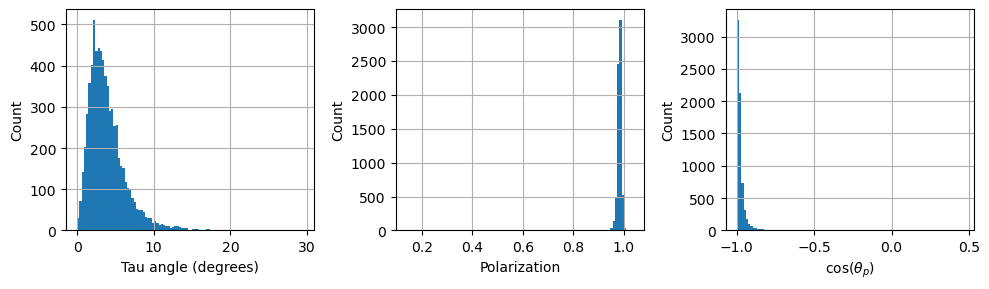

In [103]:
s = np.array(spin_vector(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(2*np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

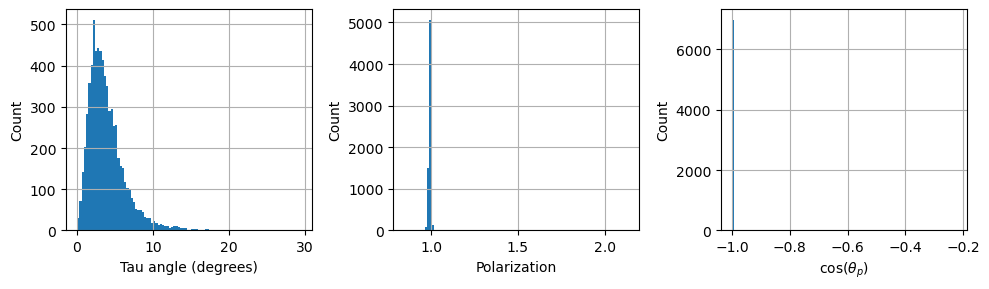

In [104]:
s = np.array(polarization_vector(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "qel",
    x=qel_events["xs"].values,
    W=qel_events["Ws"].values
    )
)

fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
axs[0].hist(tau_angles * 180/np.pi, bins=100)
axs[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

axs[1].hist(np.linalg.norm(s, axis=0), bins=100)
axs[1].set(xlabel="Polarization", ylabel="Count")

axs[2].hist(s[1] / np.linalg.norm(s, axis=0), bins=100)
axs[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for ax in axs:
    ax.grid()
    # a.set_yscale("log")

In some cases, I get a polarization vector that has magnitude > 1. Though this might not be completely incorrect, since the equations are not perfect and there might be some assumptions here and there that I break (e.g., they might always assume that the nucleon mass is 0.938 GeV, whereas that is not true and that is not the value that I pass to the code).
If $|s| > 1$, I can simply normalize the vector.

However, this is not a problem when using the spin vector equations from the tau polarization paper. Perhaps these equations are better?

## Resonance scattering

In [131]:
# Resonance scattering
# Delta mass
M_delta_res = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_Delta_0_res = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# This should not matter, as it is multiplied to all values and then divided away
kappa_res = 2/3
M_V_res = 0.84 # GeV. Maybe 0.84 GeV, see GiBUU thesis eq 5.24
C_V_3_0_res = 1.95 # Maybe 1.95, see GiBUU thesis eq 5.24

C_A_5_0_res = 1.2 # GiBUU thesis eq 5.27
C_0_res = {4: -0.3, 5: 1.2}
a_coeff_res = -1.21
b_coeff_res = 2 # GeV^2
M_A_res = 1.05 # GeV


def K(zeta, x, w, j, k, n):
    functions = {
        (3, 3, 3): lambda zeta, x, w: -2 * zeta**3 * (1 - 2*x)**2 * w**2 + 2 * zeta * (2 - 3*x) * w,
        (3, 3, 4): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (3, 3, 5): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w + 2 * (1 + zeta),
        (3, 4, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x)**2 * w**2 + 2 * (1 - zeta) * (1 - 2*x) * w,
        (3, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**2,
        (3, 4, 5): lambda zeta, x, w: zeta * (1 - 2*x) * w,
        (3, 5, 3): lambda zeta, x, w: -zeta**2 * (1 - 2*x) * w**2 - 2 * (1 - zeta) * w,
        (3, 5, 4): lambda zeta, x, w: zeta * (1 - 2*x) * w**2,
        (3, 5, 5): lambda zeta, x, w: zeta * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def A(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 - 2 * (1 - zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**2 + (1 + zeta * (2 + zeta) * (1 - 2*x)) * w,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 + (1 + zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**2 + 2 * (1 + zeta) * (1 - 2*x) * w,
        (1, 5, 5): lambda zeta, x, w: zeta * w + 1 + zeta,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 + zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 + 2 * (1 + zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w + 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 + 2 * zeta * (2 + zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w + zeta * (2 + zeta),
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 + zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 + 2 * (1 + zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 - 2 * (1 + zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w + zeta**2 * (1 + zeta),
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta * (zeta * (1 + zeta) * (1 - 2*x) - 1) * w - 2 * (1 + zeta),
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (zeta * (1 + zeta) * (1 - 2*x)**2 + 2 * x) * w**2 + 2 * (1 + zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 + zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + x) * w + (1 + zeta)**2,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 + zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 + 2 * (1 + zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 2 * zeta * w + 2 * (1 + zeta),
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 - 4 * (1 + zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 2 * zeta**3 * w + 2 * zeta**2 * (1 + zeta),
        (5, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**2 + 2 * zeta**2 * (1 + zeta) * (1 - 2*x) * w,
    }
    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)


def V(zeta, x, w, j, k, n):
    functions = {
        (1, 3, 3): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 + zeta * (1 + zeta**2 * (1 - 2*x)**2) * w**2 + 2 * (1 + zeta) * x * w,
        (1, 3, 4): lambda zeta, x, w: zeta**2 * (1 - 2*x)**2 * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * (1 - 2*x) * w**2,
        (1, 3, 5): lambda zeta, x, w: zeta**2 * (1 - 2*x) * w**3 + (1 - zeta * (2 - zeta) * (1 - 2*x)) * w**2,
        (1, 4, 4): lambda zeta, x, w: zeta * (1 - 2*x)**2 * w**3 - (1 - zeta) * (1 - 2*x)**2 * w**2,
        (1, 4, 5): lambda zeta, x, w: 2 * zeta * (1 - 2*x) * w**3 - (1 - zeta) * (1 - 4*x) * w**2,
        (1, 5, 5): lambda zeta, x, w: zeta * w**3 - (1 - zeta) * w**2,
        (2, 3, 3): lambda zeta, x, w: 2 * zeta**3 * x * w**2 + 2 * zeta * (1 + zeta**2) * x * w,
        (2, 3, 4): lambda zeta, x, w: 2 * zeta**2 * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * x * w**2 + 2 * (1 - zeta)**2 * x * w,
        (2, 4, 4): lambda zeta, x, w: 2 * zeta * x * w**2 - 2 * (1 - zeta) * x * w,
        (2, 4, 5): lambda zeta, x, w: 4 * zeta * x * w**2 - 4 * (1 - zeta) * x * w,
        (2, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x**2 * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * x * w**2 - 2 * (1 - zeta) * x * w,
        (4, 3, 3): lambda zeta, x, w: 2 * zeta**3 * (1 - x) * w**2 + 2 * zeta**3 * (1 - x) * w - 1 - zeta,
        (4, 3, 4): lambda zeta, x, w: 2 * zeta**2 * (1 - x) * w**2 + (1 - 2 * zeta * (2 - zeta) * (1 - x)) * w,
        (4, 3, 5): lambda zeta, x, w: 2 * zeta**2 * w**2 - zeta * (2 - zeta) * w,
        (4, 3, 6): lambda zeta, x, w: -2 * zeta**2 * x * w**2 - (1 - zeta)**2 * w,
        (4, 4, 4): lambda zeta, x, w: 2 * zeta * (1 - x) * w**2 - 2 * (1 - zeta) * (1 - x) * w,
        (4, 4, 5): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (4, 4, 6): lambda zeta, x, w: -2 * zeta * w**2 + 2 * (1 - zeta) * w,
        (4, 5, 5): lambda zeta, x, w: zeta**3 * w**3 - zeta**2 * (1 - zeta) * w**2,
        (4, 5, 6): lambda zeta, x, w: 2 * zeta**3 * (1 - 2*x) * w**3 - 2 * zeta * (1 + zeta * (1 - zeta) * (1 - 2*x)) * w**2 + 2 * (1 - zeta) * w,
        (4, 6, 6): lambda zeta, x, w: zeta**3 * (1 - 2*x)**2 * w**3 - zeta * (zeta * (1 - zeta) * (1 - 2*x)**2 - 2*x) * w**2 - 2 * (1 - zeta) * x * w,
        (5, 3, 3): lambda zeta, x, w: 2 * zeta**3 * w**2 + 2 * zeta * (1 + zeta**2) * w,
        (5, 3, 4): lambda zeta, x, w: 2 * zeta**2 * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 5): lambda zeta, x, w: 2 * zeta**2 * (1 + 2*x) * w**2 + 2 * (1 - zeta)**2 * w,
        (5, 3, 6): lambda zeta, x, w: -4 * zeta**2 * x**2 * w**2 - 2 * (1 - zeta)**2 * x * w,
        (5, 4, 4): lambda zeta, x, w: 2 * zeta * w**2 - 2 * (1 - zeta) * w,
        (5, 4, 5): lambda zeta, x, w: 4 * zeta * w**2 - 4 * (1 - zeta) * w,
        (5, 4, 6): lambda zeta, x, w: -4 * zeta * x * w**2 + 4 * (1 - zeta) * x * w,
        (5, 5, 5): lambda zeta, x, w: 4 * zeta**3 * x * w**3 + 2 * zeta * (1 - 2 * zeta * (1 - zeta) * x) * w**2 - 2 * (1 - zeta) * w,
        (5, 5, 6): lambda zeta, x, w: 4 * zeta**3 * (1 - 2*x) * x * w**3 - 4 * zeta * (zeta * (1 - zeta) * (1 - 2*x) + 1) * x * w**2 + 4 * (1 - zeta) * x * w,
    }

    if (n, j, k) not in functions:
        return 0
    
    return functions[(n, j, k)](zeta, x, w)

def C_V(q, W, M, j):
    if j == 3:
        # GiBUU thesis eq 5.24
        return C_V_3_0_res / (1 - q**2 / M_V_res**2)**2 / (1 - q**2 / (4*M_V_res**2))
    elif j == 4:
        # GiBUU thesis eq 5.23
        return - M / W * C_V(q, W, M, 3)
    elif j in {5, 6}:
        return 0
    else:
        raise ValueError(f"Unsupported j = {j}")
    
def C_A(q, M, j):
    # Might also be different. See GiBUU thesis eq 5.28 - 5.30
    if j == 3:
        return 0
    elif j == 6:
        return C_A(q, M, 5) * M**2 / (m_pi**2 - q**2)
    elif j == 5:
        return C_A_5_0_res / (1 - q**2 / M_A_res**2)**2 / (1 - q**2 / (3 * M_A_res**2))
    elif j == 4:
        return -C_A(q, M, 5) / 4
    else:
        raise ValueError(f"Unsupported j = {j}")

# def G_A_RS(q, M, j):
#     # TODO. See Rein-Seghal paper
#     (1-q**2 / (2*m))

def p_pi_star(W, M):
    return np.sqrt(((W**2 - M**2 + m_pi**2)/(2*W))**2 - m_pi**2)

def lambda_func(a, b, c):
    return a**2 + b**2 + c**2 - 2*(a*b + a*c + b*c)

def q_CM(W, M):
    q = (W**2 - m_pi**2 - M**2)**2 - 4*m_pi**2 * M**2
    q[q < 0] = 1
    return np.sqrt(q) / (2*W)

def Gamma_Delta(W, M):
    # NOTE according to GiBUU thesis, P-wave is more correct, as it preserves angular momentum, which S-waves do not. 
    #  This should however not affect my results, as this constant is divided away anyway.
    return Gamma_Delta_0_res * (q_CM(W, M) / q_CM(M_delta_res, M))**3
    
    # From tau polarization paper
    # return Gamma_Delta_0_res * M_delta_res / W * np.sqrt(lambda_func(W**2, M**2, m_pi**2) / lambda_func(M_delta_res**2, M**2, m_pi**2))
    
    # From lepton polarization paper, assuming S-waves (L=0).
    # return Gamma_Delta_0_res * (p_pi_star(W, M) / p_pi_star(M_delta_res, M))**3
    # Both of these seem to give the same result

def eta_delta_bw2(W, M, Gamma_Delta_f=Gamma_Delta):
    value = 1/(2*np.pi) * Gamma_Delta_f(W, M) / ((W**2 - M_delta_res**2)**2 + Gamma_Delta_f(W, M)**2 / 4)
    # If a nan value is encountered, set to 1 to not make the whole computation into nan. 
    # This is ok, because this value does not affect the final polarization anyway.
    value[np.isnan(value)] = 1
    return value

def Wnres(x, Q2, p, q, M, n, W):
    # The invariant mass of the Delta particle. 
    # This should be a sample from a Breit-Wigner distribution 
    # around the central mass M_Delta and with width Gamma_Delta
    # W = np.sqrt((p + q)**2)

    w_value = w(p, q, M)
    x = Q2 / (2*p.dot(q))
    zeta = M / M_delta_res
    
    # Since the constants are the same for all Wnres terms, they will not affect the value of the polarization, as they are divided away. This means that 
    # kappa_res * np.cos(theta_c)**2 * M * M_delta_res * eta_delta_bw2(W, M) is meaningless. 
    if n == 3:
        return (
            2 * kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
            eta_delta_bw2(W, M) * 
            sum(
                K(zeta, x, w_value, j, k, n) * C_V(q, W, M, j) * C_A(q, M, k)
                for j, k in itertools.product(range(3, 7), repeat=2)
            )
        )
    
    return (
        kappa_res * np.cos(theta_c)**2 * M * M_delta_res * 
        eta_delta_bw2(W, M) * 
        sum(
            V(zeta, x, w_value, j, k, n) * C_V(q, W, M, j) * C_V(q, W, M, k) 
            + A(zeta, x, w_value, j, k, n) * C_A(q, M, j) * C_A(q, M, k)
            for j, k in itertools.product(range(3, 7), repeat=2)
        )
    )

In [132]:
res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

taus = res_particles[res_particles["pdg"] == 15]
nutaus = res_particles.groupby("event_num").nth(1)
assert np.all(nutaus["pdg"] == 16)

tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

nucleon4m = vector.array({"E": res_events["En"], "px": res_events["pxn"], "py": res_events["pyn"], "pz": res_events["pzn"]})
nucleon4m_stationary = vector.array({"E": np.zeros(taus.shape[0]) + 0.938919, "px": np.zeros(taus.shape[0]), "py": np.zeros(taus.shape[0]), "pz": np.zeros(taus.shape[0])})

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

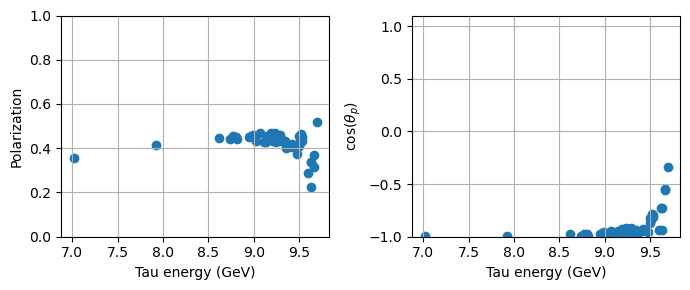

In [133]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.3

s = np.array(spin_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m_stationary[zero_angle_tau_events], 
    "res",
    x=res_events[zero_angle_tau_events.values]["x"].values,
    W=res_events[zero_angle_tau_events.values]["W"].values
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


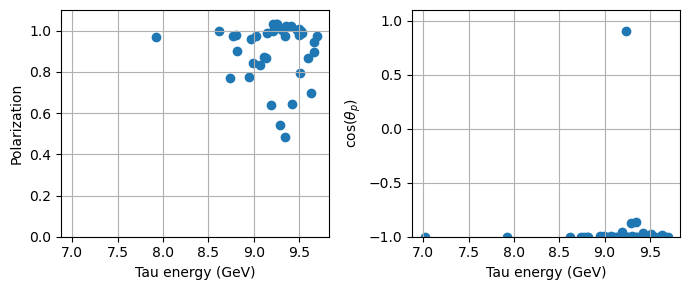

In [134]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.3

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "res",
    x=res_events[zero_angle_tau_events.values]["xs"].values,
    W=res_events[zero_angle_tau_events.values]["Ws"].values
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This plot looks strange but the other plots look good.

In [135]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.03

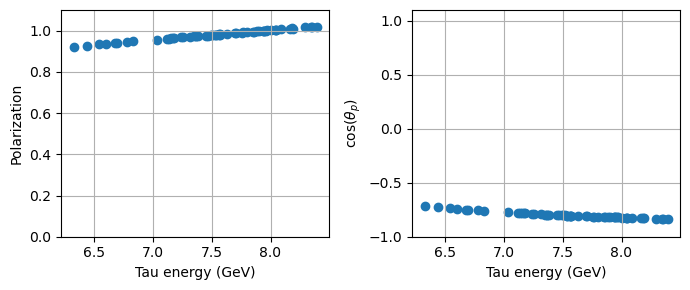

In [136]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.1
s = np.array(spin_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m_stationary[almost10deg_tau_events], 
    "res",
    x=res_events[almost10deg_tau_events.values]["x"].values,
    W=res_events[almost10deg_tau_events.values]["W"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


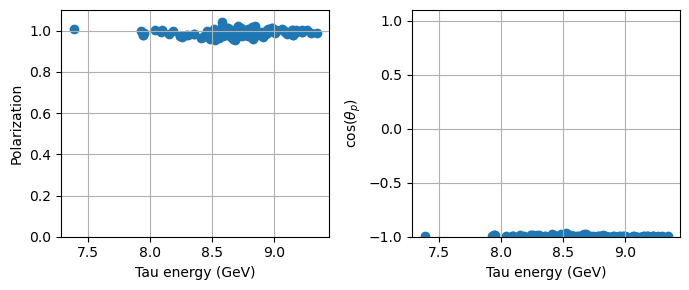

In [137]:
s = np.array(polarization_vector(
    tau4m[almost5deg_tau_events], 
    nutau4m[almost5deg_tau_events], 
    nucleon4m[almost5deg_tau_events], 
    "res",
    x=res_events[almost5deg_tau_events.values]["xs"].values,
    W=res_events[almost5deg_tau_events.values]["Ws"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


In [138]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.1

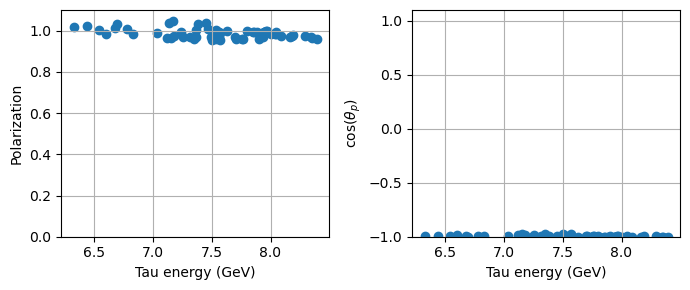

In [139]:
s = np.array(polarization_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "res",
    x=res_events[almost10deg_tau_events.values]["xs"].values,
    W=res_events[almost10deg_tau_events.values]["Ws"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


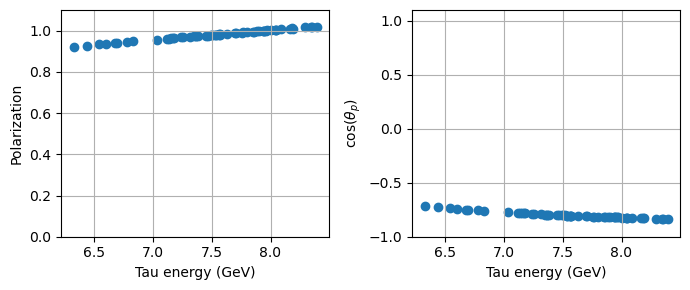

In [140]:
s = np.array(spin_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m_stationary[almost10deg_tau_events], 
    "res",
    x=res_events[almost10deg_tau_events.values]["x"].values,
    W=res_events[almost10deg_tau_events.values]["W"].values,
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


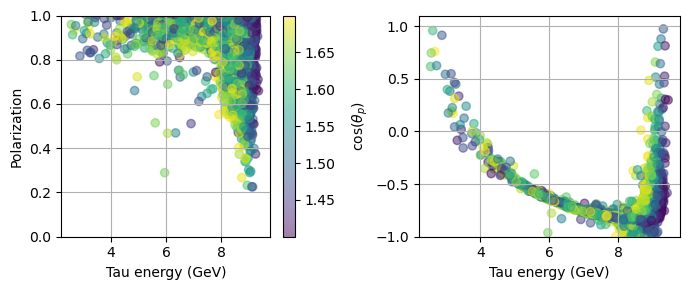

In [141]:
s = np.array(spin_vector(
    tau4m, 
    nutau4m, 
    nucleon4m, 
    "res",
    x=res_events["x"].values,
    W=res_events["W"].values,
))

q = nutau4m - tau4m
W = res_events["Ws"]
x = res_events["xs"]

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
c = axs[0].scatter(tau4m.E[W > 1.4], 2*np.linalg.norm(s, axis=0)[W > 1.4], c=W[W > 1.4], alpha=0.5)
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1))
fig.colorbar(c, ax=axs[0])
axs[1].scatter(tau4m.E[W > 1.4], (s[1] / np.linalg.norm(s, axis=0))[W > 1.4], c=W[W > 1.4], alpha=0.5)
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


In [151]:
res_events["W"].values[np.isnan(s).all(axis=0)]

array([nan])

In [119]:
assert np.isnan(s).sum() == 0

AssertionError: 

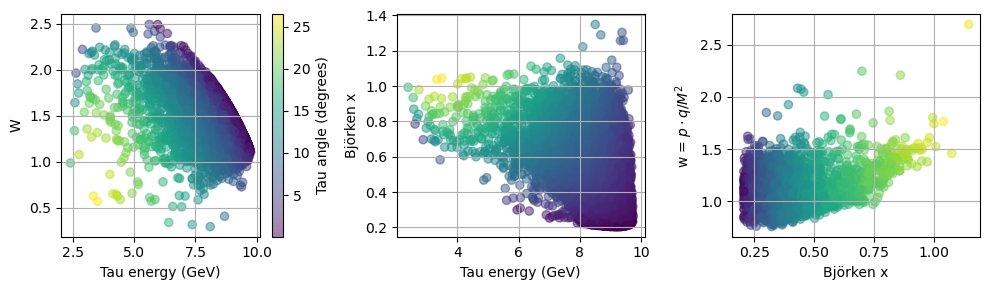

In [152]:
q = nutau4m - tau4m
W = res_events["W"]
x = res_events["x"]
zeta = nucleon4m.M / M_delta_res
w_value = w(nucleon4m, q, nucleon4m.M)
E_9_events = np.abs(tau4m.E - 9) < 0.1

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")

c = axs[0].scatter(
    tau4m.E#[zero_angle_tau_events]
    , W, c=180/np.pi * tau_angles#[zero_angle_tau_events]
    , alpha=0.5)
axs[0].set(xlabel="Tau energy (GeV)", ylabel="W")
fig.colorbar(c, ax=axs[0], label="Tau angle (degrees)")

axs[1].scatter(
    tau4m.E#[zero_angle_tau_events]nucleon4m
    , x, c=180/np.pi * tau_angles#[zero_angle_tau_events]
    , alpha=0.5)
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"Björken x")

axs[2].scatter(
    x[E_9_events]
    , w_value[E_9_events]
    , c=180/np.pi * tau_angles[E_9_events]
    , alpha=0.5)
axs[2].set(xlabel="Björken x", ylabel=r"w = $p\cdot q/M^2$")

for ax in axs:
    ax.grid()


Check how many events have a small angle relative to the neutrino and is a resonance event. The polarization vector of these events do not match the figure in the tau polarization paper. If it is onlt a few number of events, it should not be a big problem.

In [153]:
for e in (5, 10, 20, 50, 100):
    events = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info.csv")
    taus = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv").query("pdg == 15")
    tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
    assert np.all(tau_angles > 0)
    n_bad_events = np.sum((np.abs(tau_angles) < 2) & events["res"])
    print(f"{e} GeV: {n_bad_events} bad events out of {events.shape[0]} events ({n_bad_events / events.shape[0] * 100:.2f}%)")

5 GeV: 138 bad events out of 17881 events (0.77%)
10 GeV: 260 bad events out of 42493 events (0.61%)
20 GeV: 216 bad events out of 56282 events (0.38%)
50 GeV: 112 bad events out of 66363 events (0.17%)
100 GeV: 82 bad events out of 70093 events (0.12%)


## Deep inelastic scattering

In [188]:
# Deep inelastic scattering
# The PDFs used in GENIE seems to bee CT10nlo, member 0 from LHAPDF. Source: https://github.com/GENIE-MC/Generator/blob/master/config/LHAPDF6.xml
# I should therefore probably use the same here
pdfset = lhapdf.mkPDF("CT10nlo", 0)
def pdf(quark, x, Q2):
    # Division by x might be wrong.
    # Probably does not have an effect on the result, since all PDFs are divided by the value
    f = pdfset.xfxQ2(quark, x, Q2) / x
    return np.array(f)


def mass_corrected_xi(x, Q2, charm):
    xi = x.copy()
    m_charm = 1.27 # GeV
    # If a charm quark is produced, replace x with xi
    xi[charm] = x[charm] / (Q2[charm] / (Q2[charm] + m_charm**2))
    # Cap the x to 1
    xi[xi > 1] = 1
    # print(xi)
    return xi

def W1dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis_pdf(x, Q2, p, q, M, charm):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdf(quark, xi, Q2) for quark in range(1, 7)], axis=0)
        - np.sum([pdf(quark, xi, Q2) for quark in range(-6, 0)], axis=0)
    )

def W4dis_pdf(x, Q2, p, q, M, charm):
    return 0

def W5dis_pdf(x, Q2, p, q, M, charm):
    # In the tau polarization paper, there is a factor of 2 in front. 
    xi = mass_corrected_xi(x, Q2, charm)
    
    # I am not sure if this is a mistake, convention difference, or something else
    return 1/w(p, q, M) * 2 * np.sum([pdf(quark, xi, Q2) for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 


LHAPDF 6.5.4 loading /home/simon/miniconda3/envs/cern-skhep/share/LHAPDF/CT10nlo/CT10nlo_0000.dat
CT10nlo PDF set, member #0, version 4; LHAPDF ID = 11000


In [189]:
def W1dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        # Correction, see eq. 55 in tau polarization paper. 
        (1 + xi/w(p, q, M)) * 
        np.sum([pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F1
    )

def W2dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return (
        1/w(p, q, M) 
        * 2 * np.sum([xi * pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # F2
    )

def W3dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    return 1/w(p, q, M) * 2 * (
        np.sum([pdfvalues[quark] / x for quark in range(1, 7)], axis=0)
        - np.sum([pdfvalues[quark] / x for quark in range(-6, 0)], axis=0)
    )

def W4dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    return 0

def W5dis_grv(x, Q2, p, q, M, charm, pdfvalues):
    xi = mass_corrected_xi(x, Q2, charm)
    
    return 1/w(p, q, M) * 2 * np.sum([pdfvalues[quark] / x for quark in [*range(1, 7), *range(-6, 0)]], axis=0) # W1dis(x, Q2, p, q, M, charm) * 


In [190]:
def Wndis_f(x, Q2, p, q, M, charm, pdfvalues, n):
    if n == 1:
        return pdfvalues[f"F{n}"].values

    return 1/w(p, q, M) * pdfvalues[f"F{n}"].values

In [191]:
def get_pdf_values(dis_events):
    pdfvalues = {}

    assert dis_events.loc[:, "fuv":"fc"].notnull().all().all()

    pdfvalues["event_num"] = dis_events["event_num"]
    # down-quark
    pdfvalues[1] = (dis_events["fdv"] + dis_events["fds"]).values
    # up-quark
    pdfvalues[2] = (dis_events["fuv"] + dis_events["fus"]).values
    # strange-quark
    pdfvalues[3] = dis_events["fs"].values
    # charm-quark
    pdfvalues[4] = dis_events["fc"].values
    # bottom-quark
    pdfvalues[5] = np.zeros(dis_events.shape[0])
    # top-quark
    pdfvalues[6] = np.zeros(dis_events.shape[0])

    # dbar-quark
    pdfvalues[-1] = dis_events["fds"].values
    # ubar-quark
    pdfvalues[-2] = dis_events["fus"].values
    # sbar-quark
    pdfvalues[-3] = dis_events["fs"].values
    # cbar-quark
    pdfvalues[-4] = dis_events["fc"].values
    # bbar-quark
    pdfvalues[-5] = np.zeros(dis_events.shape[0])
    # tbar-quark
    pdfvalues[-6] = np.zeros(dis_events.shape[0])

    pdfvalues = pd.DataFrame(pdfvalues)

    return pdfvalues

In [192]:
dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]

dis_events = event_info[event_info["dis"]]

taus = dis_particles[dis_particles["pdg"] == 15]
nutaus = dis_particles.groupby("event_num").nth(1)

assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])


nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
# nucleon_mass = np.ones(nucleons.shape[0]) * 0.938919 #14.895082 / 16
# nucleon_mass[nucleons["pdg"] < 1e5] = nucleons[nucleons["pdg"] < 1e5]["E"]
nucleon4m = vector.array({"E": dis_events["En"], "px": dis_events["pxn"], "py": dis_events["pyn"], "pz": dis_events["pzn"]})
nucleon4m_stationary = vector.array({"E": 0.98318 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})

q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

pdfvalues = get_pdf_values(dis_events)

fvalues = dis_events.loc[:, "F1":"F5"]

KeyError: 'fuv'

In [187]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(spin_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m_stationary[zero_angle_tau_events], 
    "dis_f",
    x=dis_events[zero_angle_tau_events.values]["xs"].values,
    W=dis_events[zero_angle_tau_events.values]["Ws"].values,
    charm=dis_events.loc[zero_angle_tau_events.values, "charm"].values,
    pdfvalues=fvalues[zero_angle_tau_events.values],
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


ValueError: Item wrong length 68380 instead of 21386.

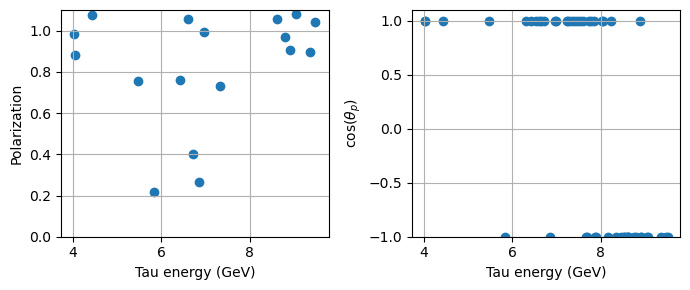

In [161]:
zero_angle_tau_events = (tau_angles * 180/np.pi) < 0.4

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis_f",
    x=dis_events[zero_angle_tau_events.values]["xs"].values,
    W=dis_events[zero_angle_tau_events.values]["Ws"].values,
    charm=dis_events.loc[zero_angle_tau_events.values, "charm"].values,
    pdfvalues=fvalues[zero_angle_tau_events.values],
))

# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like it should! See tau polarization paper, figure 6, right column

In [162]:
almost5deg_tau_events = np.abs(tau_angles * 180/np.pi - 5) < 0.03

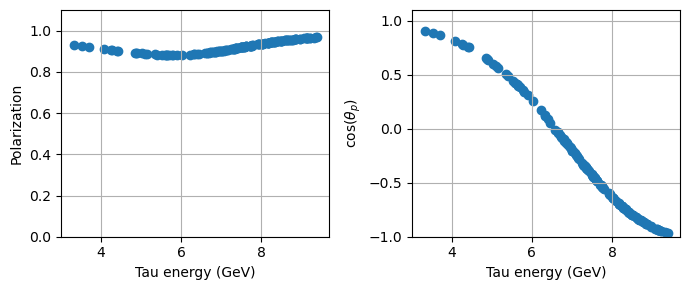

In [163]:
s = np.array(spin_vector(
    tau4m[almost5deg_tau_events], 
    nutau4m[almost5deg_tau_events], 
    nucleon4m_stationary[almost5deg_tau_events], 
    "dis_f",
    x=dis_events[almost5deg_tau_events.values]["x"].values,
    W=dis_events[almost5deg_tau_events.values]["W"].values,
    charm=dis_events.loc[almost5deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost5deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


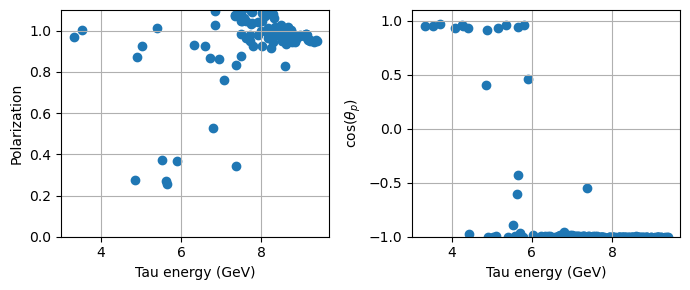

In [164]:
s = np.array(polarization_vector(
    tau4m[almost5deg_tau_events], 
    nutau4m[almost5deg_tau_events], 
    nucleon4m[almost5deg_tau_events], 
    "dis_f",
    x=dis_events[almost5deg_tau_events.values]["xs"].values,
    W=dis_events[almost5deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost5deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost5deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost5deg_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost5deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This looks exactly like Figure 6, center column in the tau polarization paper

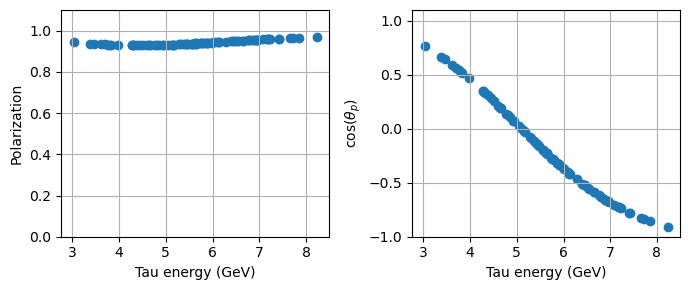

In [165]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(spin_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m_stationary[almost10deg_tau_events], 
    "dis_f",
    x=dis_events[almost10deg_tau_events.values]["x"].values,
    W=dis_events[almost10deg_tau_events.values]["W"].values,
    charm=dis_events.loc[almost10deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost10deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, 2*np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


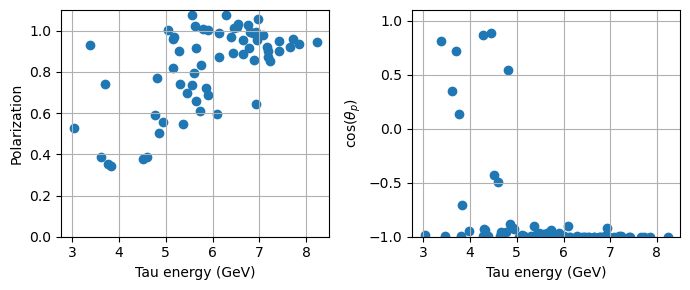

In [166]:
almost10deg_tau_events = np.abs(tau_angles * 180/np.pi - 10) < 0.03
# Drop all x where it is unphysical. This will change later once I have access to W
q = nutau4m - tau4m
x = -q**2 / (2*nucleon4m.dot(q))
almost10deg_tau_events.iloc[x > 1] = False

s = np.array(polarization_vector(
    tau4m[almost10deg_tau_events], 
    nutau4m[almost10deg_tau_events], 
    nucleon4m[almost10deg_tau_events], 
    "dis_f",
    x=dis_events[almost10deg_tau_events.values]["xs"].values,
    W=dis_events[almost10deg_tau_events.values]["Ws"].values,
    charm=dis_events.loc[almost10deg_tau_events.values, "charm"].values,
    pdfvalues=fvalues[almost10deg_tau_events.values],
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[almost10deg_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
axs[1].scatter(tau4m[almost10deg_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs:
    ax.grid()


This plot also looks exactly like it should! See tau polarization paper, figure 6, right column

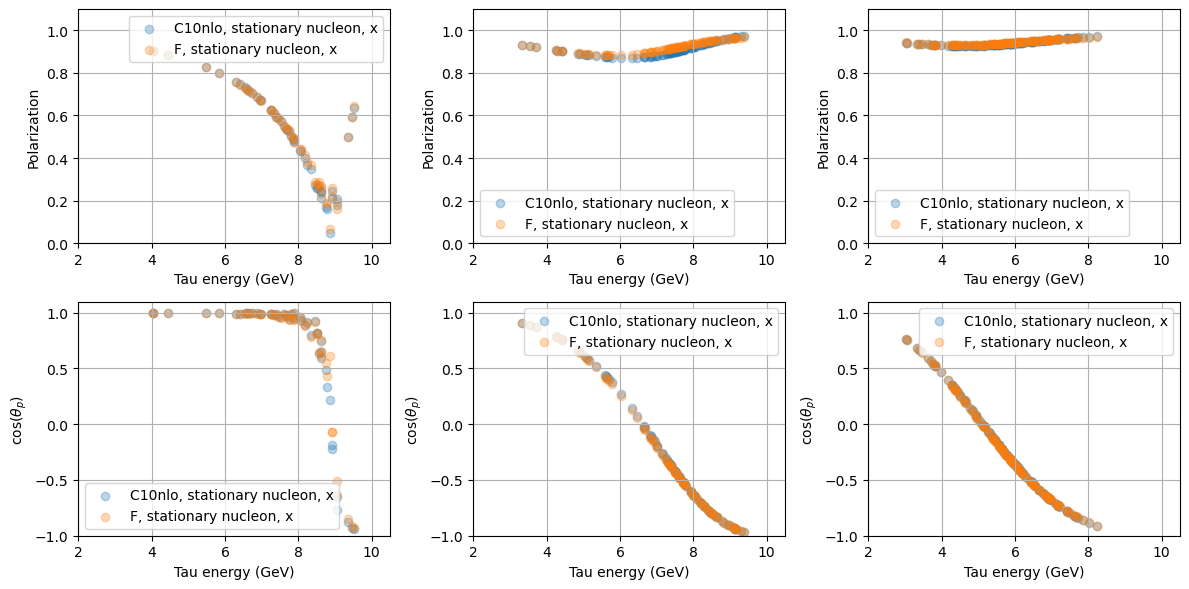

In [167]:
taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi

assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.02, 0.05)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]
    
    selected_particles = dis_particles[dis_particles["event_num"].isin(good_angle_events["event_num"])]
    selected_events = dis_events[dis_events["event_num"].isin(good_angle_events["event_num"])]
    
    selected_taus = selected_particles[selected_particles["pdg"] == 15]
    selected_nus = selected_particles.groupby("event_num").nth(1)
    
    tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
    nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
    
    nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})
    nucleon4m_stationary = vector.array({"E": 0.98318 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})

    selected_pdfvalues = pdfvalues[dis_events["event_num"].isin(good_angle_events["event_num"])]
    selected_fvalues = fvalues[dis_events["event_num"].isin(good_angle_events["event_num"])]

    for int_type, df, nuc4m, x, label in (
        ("dis_pdf", None, nucleon4m_stationary, selected_events["x"].values, "C10nlo, stationary nucleon, x"), 
        # ("dis_grv", selected_pdfvalues, nucleon4m_stationary, selected_events["x"].values, "GRV98lo, stationary nucleon, x"), 
        ("dis_f", selected_fvalues, nucleon4m_stationary, selected_events["x"].values, "F, stationary nucleon, x"),
        ):

        s = np.array(spin_vector(
            tau4m, 
            nutau4m,
            nuc4m,
            int_type,
            x=x,
            W=selected_events["W"].values,
            charm=selected_events["charm"].values,
            pdfvalues=df,
        ))

        ax_col[0].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=label, alpha=0.3)
        ax_col[1].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=label, alpha=0.3)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

## Combined plot
Plot all interaction types for the three different angles.

This is a recreation of Figure 6 in the tau polarization paper

Text(0.5, 0.98, 'Using nucleon 4-momentum')

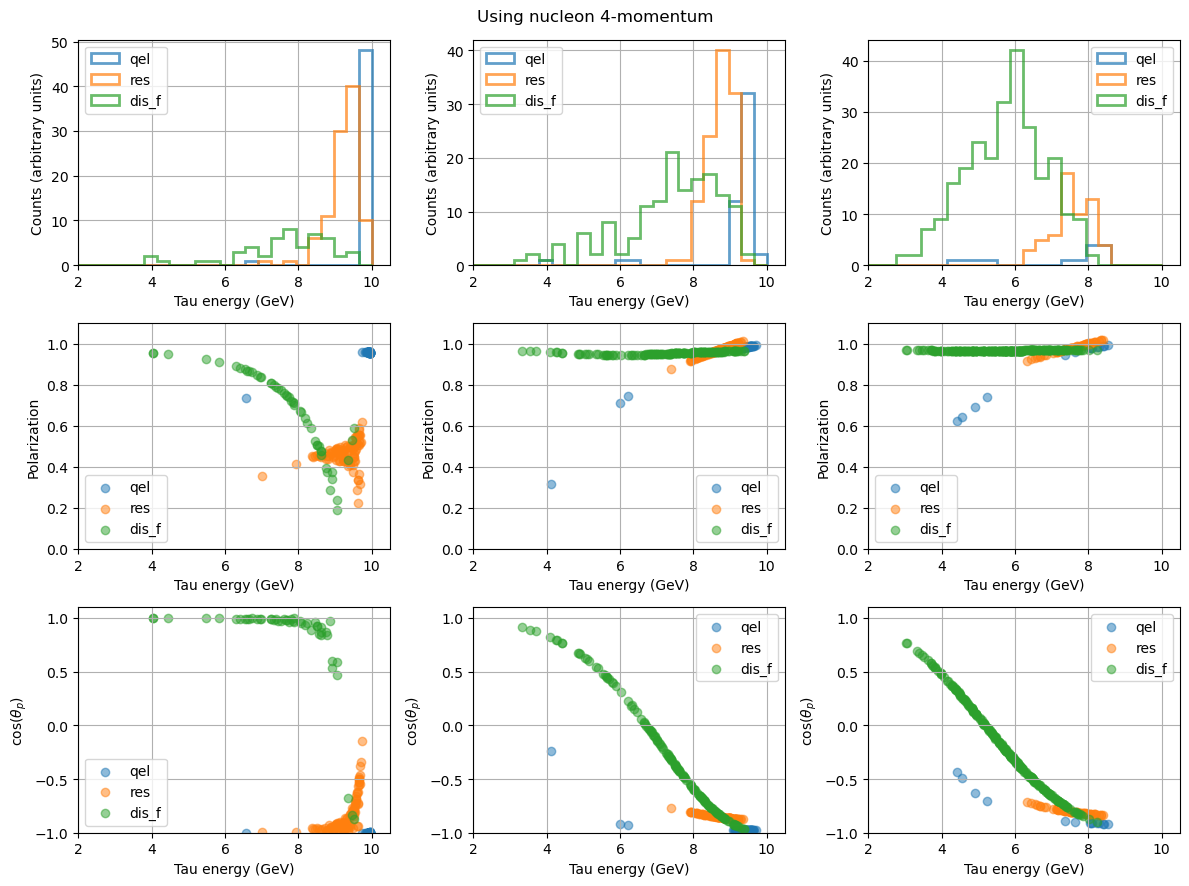

In [168]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
dis_events = event_info[event_info["dis"]]

taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.03, 0.1)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]

    for particles, events, int_type in zip((qel_particles, res_particles, dis_particles), (qel_events, res_events, dis_events), ("qel", "res", "dis_f")):
        selected_particles = particles[particles["event_num"].isin(good_angle_events["event_num"])]
        selected_events = events[events["event_num"].isin(good_angle_events["event_num"])]
        selected_taus = selected_particles[selected_particles["pdg"] == 15]
        selected_nus = selected_particles.groupby("event_num").nth(1)
        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
        # nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})
        nucleon4m = vector.array({"E": 0.938919 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})

        selected_fvalues = None

        if int_type == "dis_f":
            selected_fvalues = fvalues[events["event_num"].isin(good_angle_events["event_num"])]
        
        if int_type == "dis_grv":
            selected_fvalues = pdfvalues[events["event_num"].isin(good_angle_events["event_num"])]

        # print(int_type)
        s = np.array(spin_vector(
            tau4m, 
            nutau4m,
            nucleon4m,
            int_type,
            x=selected_events["x"].values,
            W=selected_events["W"].values,
            charm=selected_events["charm"].values,
            pdfvalues=selected_fvalues,
        ))
        if np.isnan(s).any():
            print(f"NaN: {angle=}, {int_type=}", np.isnan(s).sum(axis=1))

        ax_col[0].hist(tau4m.E, bins=np.linspace(0, 10, 30), histtype="step", label=int_type, lw=2, alpha=0.7)
        ax_col[1].scatter(tau4m.E, 2 * np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
        ax_col[2].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Counts (arbitrary units)")
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[2].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

fig.suptitle("Using nucleon 4-momentum")

Text(0.5, 0.98, 'Using nucleon 4-momentum')

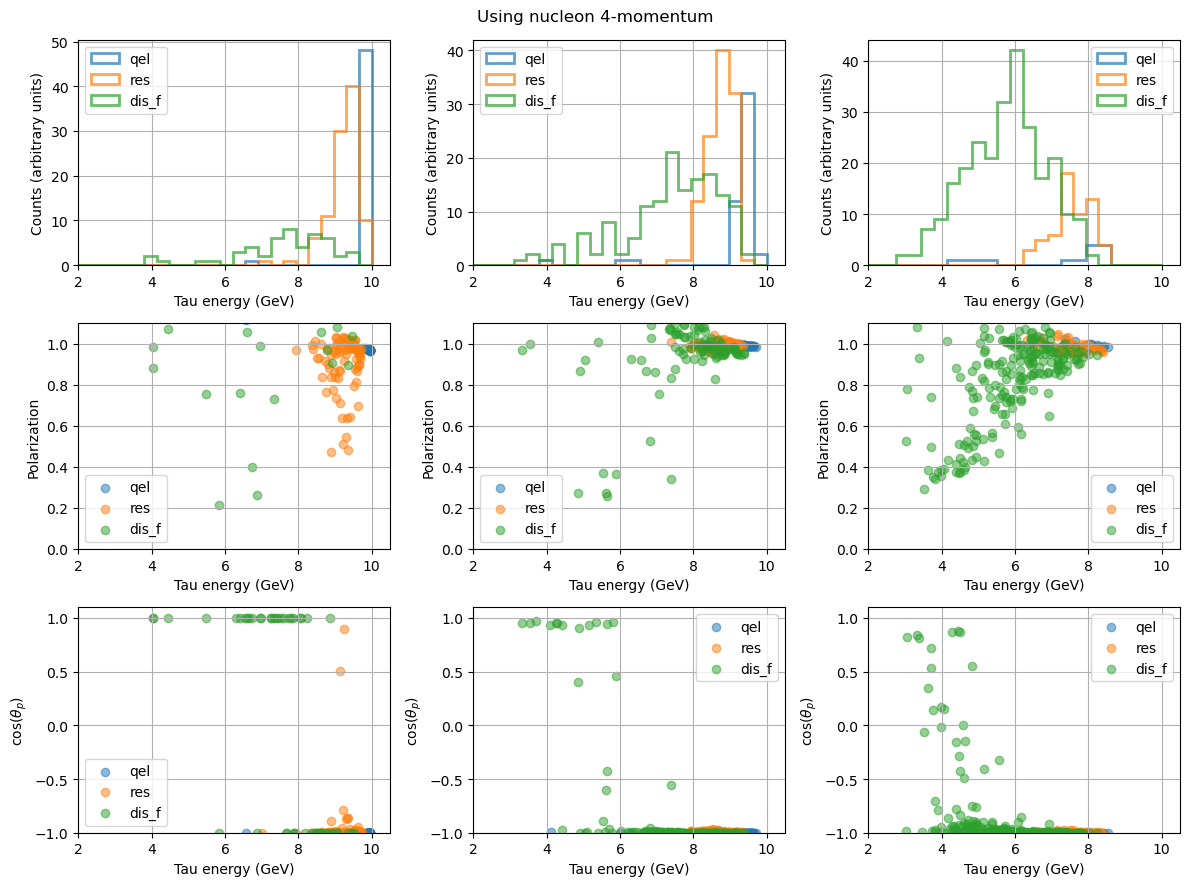

In [169]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
qel_events = event_info[event_info["qel"]]

res_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["res"], "event_num"].values)
]
res_events = event_info[event_info["res"]]

dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
dis_events = event_info[event_info["dis"]]

taus = particle_info[particle_info["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"]) * 180/np.pi
assert np.all(tau_angles > 0)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 9), layout="tight")

for ax_col, angle, angle_limit in zip(axs.T, (0, 5, 10), (0.4, 0.03, 0.1)):
    good_angle_events = taus[np.abs(tau_angles - angle) < angle_limit]

    for particles, events, int_type in zip((qel_particles, res_particles, dis_particles), (qel_events, res_events, dis_events), ("qel", "res", "dis_f")):
        selected_particles = particles[particles["event_num"].isin(good_angle_events["event_num"])]
        selected_events = events[events["event_num"].isin(good_angle_events["event_num"])]
        selected_taus = selected_particles[selected_particles["pdg"] == 15]
        selected_nus = selected_particles.groupby("event_num").nth(1)
        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
        nucleon4m = vector.array({"E": selected_events["En"], "px": selected_events["pxn"], "py": selected_events["pyn"], "pz": selected_events["pzn"]})
        # nucleon4m = vector.array({"E": 0.938919 * np.ones(tau4m.shape[0]), "px": np.zeros(tau4m.shape[0]), "py": np.zeros(tau4m.shape[0]), "pz": np.zeros(tau4m.shape[0])})

        selected_fvalues = None

        if int_type == "dis_f":
            selected_fvalues = fvalues[events["event_num"].isin(good_angle_events["event_num"])]
        
        if int_type == "dis_grv":
            selected_fvalues = pdfvalues[events["event_num"].isin(good_angle_events["event_num"])]

        # print(int_type)
        s = np.array(polarization_vector(
            tau4m, 
            nutau4m,
            nucleon4m,
            int_type,
            x=selected_events["xs"].values,
            W=selected_events["Ws"].values,
            charm=selected_events["charm"].values,
            pdfvalues=selected_fvalues,
        ))
        if np.isnan(s).any():
            print(f"NaN: {angle=}, {int_type=}", np.isnan(s).sum(axis=1))

        ax_col[0].hist(tau4m.E, bins=np.linspace(0, 10, 30), histtype="step", label=int_type, lw=2, alpha=0.7)
        ax_col[1].scatter(tau4m.E, np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
        ax_col[2].scatter(tau4m.E, s[1] / np.linalg.norm(s, axis=0), label=int_type, alpha=0.5)
    
    ax_col[0].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Counts (arbitrary units)")
    ax_col[1].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel="Polarization", ylim=(0, 1.1))
    ax_col[2].set(xlim=(2, 10.5), xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$", ylim=(-1, 1.1))

for ax in axs.flat:
    ax.grid()
    ax.legend()

fig.suptitle("Using nucleon 4-momentum")

## Change all polarization vectors for IceCube events

/tmp/ipykernel_4202/4103940153.py:181: RuntimeWarning: invalid value encountered in divide
  -mtau*np.sin(theta)/2 *
/tmp/ipykernel_4202/4103940153.py:185: RuntimeWarning: invalid value encountered in divide
  -1/2 * (
/tmp/ipykernel_4202/4103940153.py:181: RuntimeWarning: invalid value encountered in divide
  -mtau*np.sin(theta)/2 *
/tmp/ipykernel_4202/4103940153.py:185: RuntimeWarning: invalid value encountered in divide
  -1/2 * (
/tmp/ipykernel_4202/4103940153.py:181: RuntimeWarning: invalid value encountered in divide
  -mtau*np.sin(theta)/2 *
/tmp/ipykernel_4202/4103940153.py:185: RuntimeWarning: invalid value encountered in divide
  -1/2 * (
/tmp/ipykernel_4202/4103940153.py:181: RuntimeWarning: invalid value encountered in divide
  -mtau*np.sin(theta)/2 *
/tmp/ipykernel_4202/4103940153.py:185: RuntimeWarning: invalid value encountered in divide
  -1/2 * (


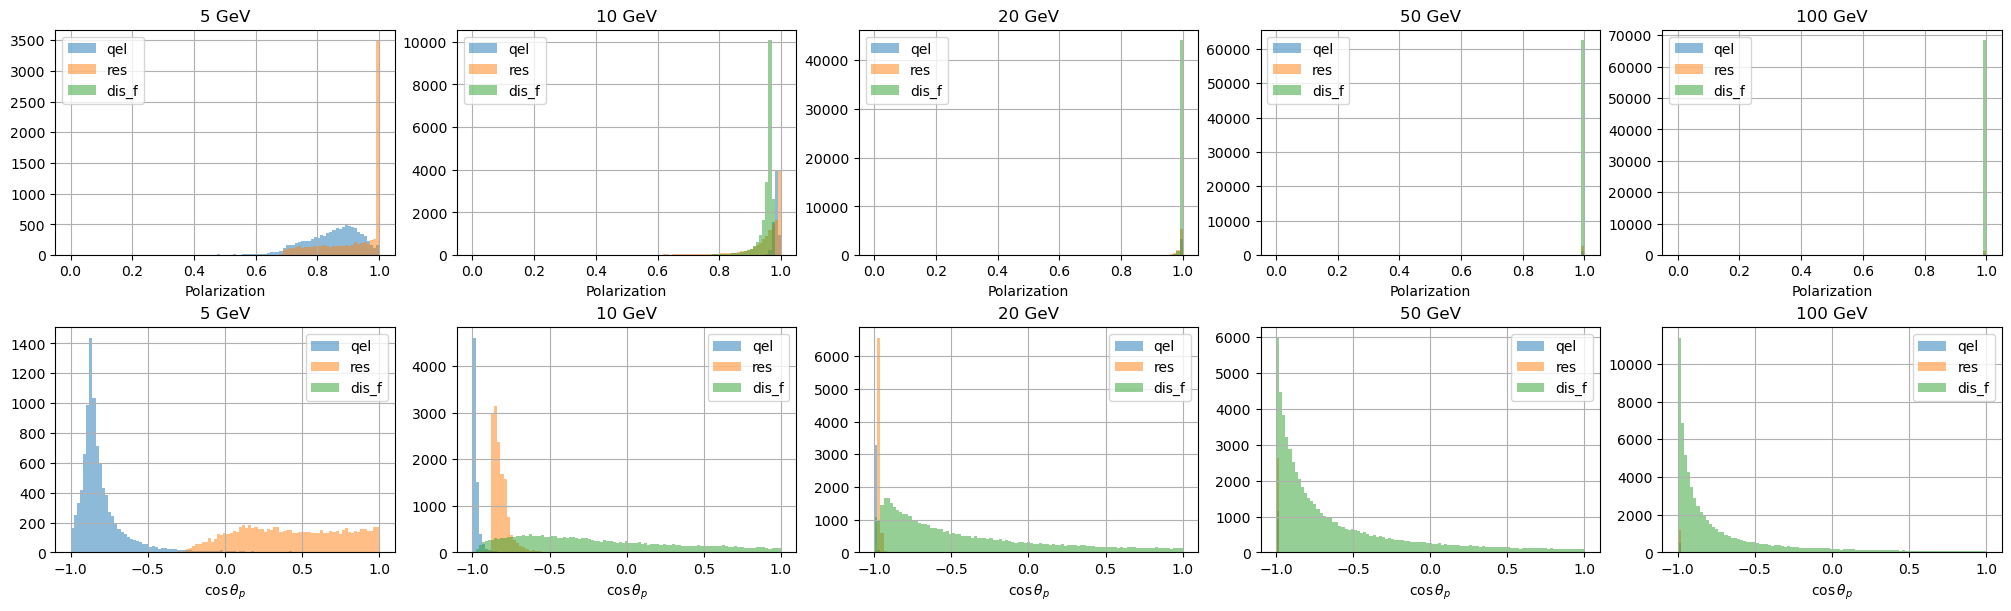

In [213]:
neutrino_energies = (5, 10, 20, 50, 100)

fig, axs = plt.subplots(nrows=2, ncols=len(neutrino_energies), figsize=(4*len(neutrino_energies), 6), layout="constrained")

for e, ax_col in zip(neutrino_energies, axs.T):
    # Load files
    particle_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_particles.csv")
    event_info = pd.read_csv(f"../data/test_genie_NuTau_{e}.0_GeV_event_info_f.csv")

    pols = pd.DataFrame() # columns=["polx", "poly", "polz", "event_num"]

    for int_type in ("qel", "res", "dis_f"):
        # Select qel, res and dis particles
        if int_type.find("_") != -1:
            int_type_col = int_type.split("_")[0]
        else:
            int_type_col = int_type

        events = event_info[event_info[int_type_col]]

        particles = particle_info[
            particle_info["event_num"]
            .isin(events.loc[events[int_type_col], "event_num"].values)
        ]

        selected_taus = particles[particles["pdg"] == 15]
        selected_nus = particles.groupby("event_num").nth(1)

        tau4m = vector.array({"E": selected_taus["E"], "px": selected_taus["px"], "py": selected_taus["py"], "pz": selected_taus["pz"]})
        nutau4m = vector.array({"E": selected_nus["E"], "px": selected_nus["px"], "py": selected_nus["py"], "pz": selected_nus["pz"]})
        nucleon4m = vector.array({"E": np.ones(selected_nus.shape[0]) * 0.938919, "px": np.zeros(selected_nus.shape[0]), "py": np.zeros(selected_nus.shape[0]), "pz": np.zeros(selected_nus.shape[0])})

        df = None
        if int_type == "dis_f":
            df = events.loc[:, "F1":"F5"]
        elif int_type == "dis_grv":
            df = get_pdf_values(events)

        s = np.array(spin_vector(
            tau4m,
            nutau4m,
            nucleon4m,
            int_type,
            x=events["xs"].values,
            W=events["Ws"].values,
            charm=events["charm"].values,
            pdfvalues=df,
        ))

        p = 2 * np.linalg.norm(s, axis=0)
        # Set maximum polarization to 1
        p[p > 1] = 1
        ax_col[0].hist(p, bins=np.linspace(0, 1, 100), label=int_type, alpha=0.5)
        ax_col[1].hist(s[1] / np.linalg.norm(s, axis=0), bins=np.linspace(-1, 1, 100), label=int_type, alpha=0.5)
        
        # Project the first component of the polarization vector onto the plane of the tau lepton and the neutrino
        # Take the x and y components of the tau lepton, make a unit vector of them, and make its length equal to the value of the first component of the polarization vector
        tau_xy_vec = vector.array({"px": tau4m["px"], "py": tau4m["py"], "pz": np.zeros(tau4m.shape[0])})
        tau_xy_unit = tau_xy_vec / tau_xy_vec.p
        tau_xy_pol_component = tau_xy_unit * s[0] * 2 # Multiply by 2 since the spin vector is 1/2
        # Concatenate the data with the pols dataframe
        pols = pd.concat([pols, pd.DataFrame({"event_num": selected_taus["event_num"], "polx": tau_xy_pol_component["x"], "poly": tau_xy_pol_component["y"], "polz": s[1] * 2})])
    
    # Fill in the missing polarizations with 0, i.e. assume that they are unpolarized.
    events_not_in_pols = event_info.loc[~event_info["event_num"].isin(pols["event_num"].values), "event_num"].unique()
    # TODO for other interactions, we assume unpolarized (or fully left-handed is a better approximation perhaps?)
    pols = pd.concat([pols, pd.DataFrame({"event_num": events_not_in_pols, "polx": np.zeros(events_not_in_pols.shape[0]), "poly": np.zeros(events_not_in_pols.shape[0]), "polz": np.zeros(events_not_in_pols.shape[0])})])
    # TODO fix the ones with NaN values
    pols = pols.fillna(0).sort_values("event_num")

    pols.to_csv(f"../data/NuTau_{e}.0_GeV_tau.csv", index=False)

    ax_col[0].set(title=f"{e} GeV", xlabel="Polarization")
    ax_col[1].set(title=f"{e} GeV", xlabel=r"$\cos\theta_p$")

for ax in axs.flat:
    ax.grid(True)
    ax.legend()

In [208]:
pols.isnull().sum()

polx         0
poly         0
polz         0
event_num    0
dtype: int64

## Load my own GENIE events
For testing and evaluating W and Q2 values, I will use my own GENIE events.

In [82]:
import uproot

with uproot.open("../data/gntp.0.gst.root") as f:
    tree = f["gst"]
    qel = tree["qel"].array()
    res = tree["res"].array()
    dis = tree["dis"].array()
    cc = tree["cc"].array()
    taus = vector.array({"E": tree["El"].array(), "px": tree["pxl"].array(), "py": tree["pyl"].array(), "pz": tree["pzl"].array()})
    Q2 = tree["Q2s"].array()
    W = tree["Ws"].array()
    Ev = tree["Ev"].array()
    charm = tree["charm"].array()
    resid = tree["resid"].array()
    nucleons = vector.array({"E": tree["En"].array(), "px": tree["pxn"].array(), "py": tree["pyn"].array(), "pz": tree["pzn"].array()}) 
    xs = tree["xs"].array()

nutaus = vector.array({"E": Ev, "px": np.zeros(len(Ev)), "py": np.zeros(len(Ev)), "pz": Ev})

In [83]:
q = nutaus - taus
M = -q.E + np.sqrt(W**2 + q.px**2 + q.py**2 + q.pz**2)

[Text(0.5, 0, 'Nucleon pz (GeV)'), Text(0, 0.5, 'Counts')]

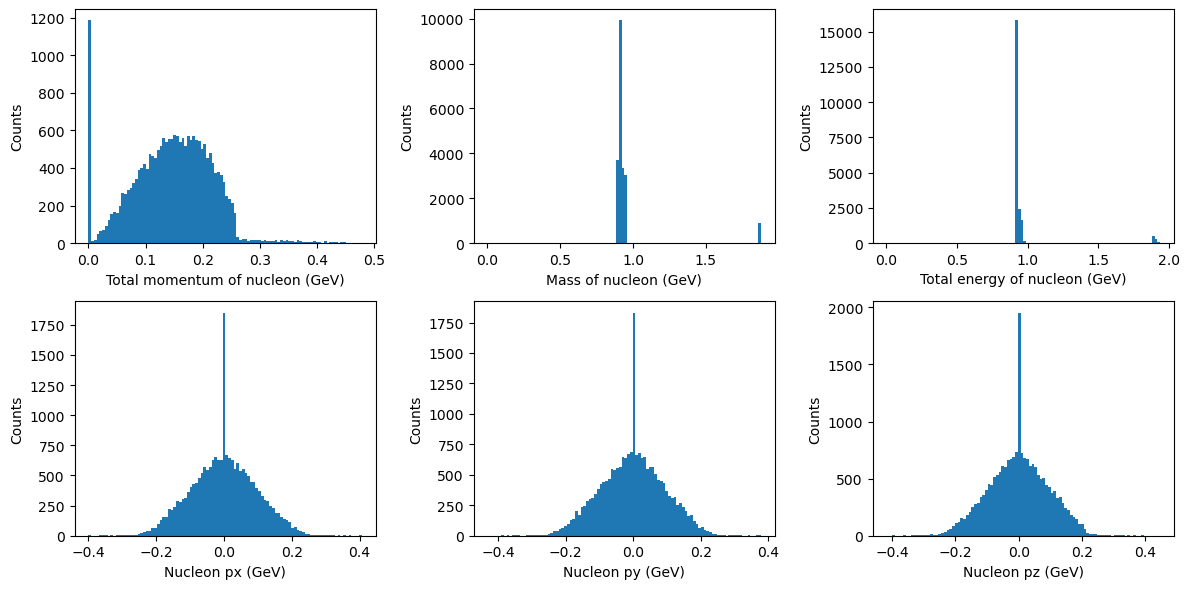

In [84]:
# Plot total momentum of nucleon, mass of nucleon and total energy of nucleon in separate subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), layout="tight")
axs[0, 0].hist(nucleons[cc].p, bins=100)
axs[0, 0].set(xlabel="Total momentum of nucleon (GeV)", ylabel="Counts")
axs[0, 1].hist(nucleons[cc].M, bins=100)
axs[0, 1].set(xlabel="Mass of nucleon (GeV)", ylabel="Counts")
axs[0, 2].hist(nucleons[cc].E, bins=100)
axs[0, 2].set(xlabel="Total energy of nucleon (GeV)", ylabel="Counts")

axs[1, 0].hist(nucleons[cc].px, bins=100)
axs[1, 0].set(xlabel="Nucleon px (GeV)", ylabel="Counts")
axs[1, 1].hist(nucleons[cc].py, bins=100)
axs[1, 1].set(xlabel="Nucleon py (GeV)", ylabel="Counts")
axs[1, 2].hist(nucleons[cc].pz, bins=100)
axs[1, 2].set(xlabel="Nucleon pz (GeV)", ylabel="Counts")


In [79]:
np.sum(np.isclose((Q2 / (W**2 + Q2 - nucleons.M**2))[cc], xs[cc], atol=1e-1))

17942

In [77]:
(Q2 / (W**2 + Q2 - nucleons.M**2))[cc], xs[cc]

(<Array [0.571, 0.123, 0.834, ..., 0.41, 0.204, 0.352] type='20955 * float64'>,
 <Array [0.571, 0.123, 0.834, ..., 0.41, 0.686, 0.352] type='20955 * float64'>)

In [87]:
(Q2 / (2*nucleons.dot(q)))[cc], xs[cc]

(<Array [0.571, 0.113, 0.834, ..., 0.41, 1.8, 0.352] type='20955 * float64'>,
 <Array [0.571, 0.123, 0.834, ..., 0.41, 0.686, 0.352] type='20955 * float64'>)

In [152]:
atan_angle = np.arctan(np.sqrt(taus.px **2 + taus.py**2) / taus.pz)
deltaangle = nutaus.deltaangle(taus)
assert np.allclose(np.arctan2(np.sqrt(taus.px**2 + taus.py**2), taus.pz), nutaus.deltaangle(taus))

vec2d = vector.array({"x": taus.pz, "y": np.sqrt(taus.px**2 + taus.py**2)})
assert np.allclose(vec2d.phi, deltaangle)

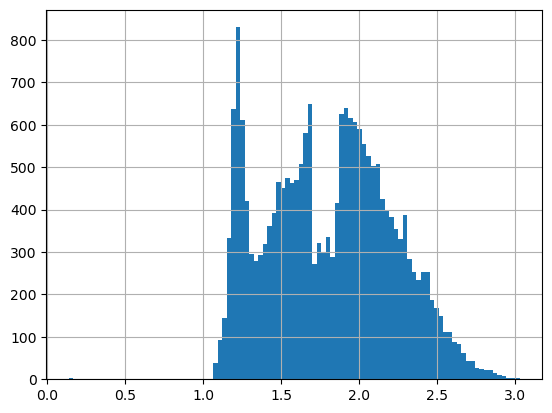

In [73]:
# W2 = (M + q.E)**2 - q.px**2 - q.py**2 - q.pz**2
plt.hist(W[cc], bins=100)
plt.grid()

In [74]:
np.sum(W > 2) / len(W)

0.50026

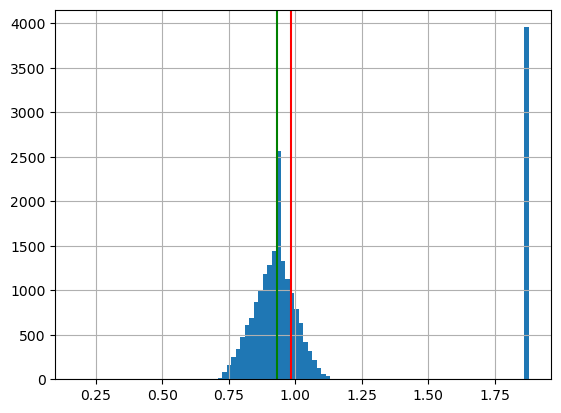

In [75]:
plt.hist(M[cc], bins=100)
plt.grid()
plt.axvline(0.983, c="r")
plt.axvline(14.895082 / 16, c="g")

In [77]:
np.sum(Q2 < 0)

12

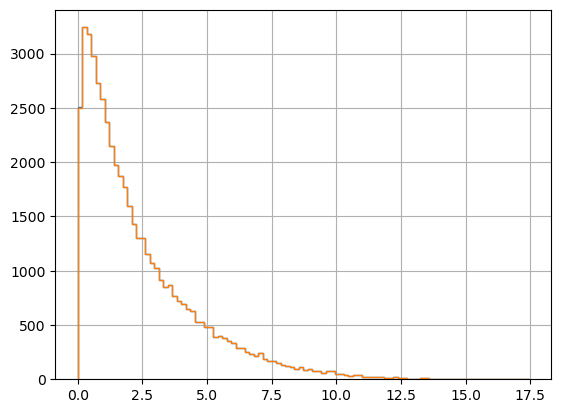

In [81]:
q2 = np.array(Q2)
q2[q2 < 0] = np.nan
plt.hist(-q**2, bins=100, histtype="step")
plt.hist(q2, bins=100, histtype="step")
plt.grid()

Q2s, Q2 and `-q**2` follow each other perfectly. This is a good cross-check. This means that I can safely use `-q**2` everywhere. 

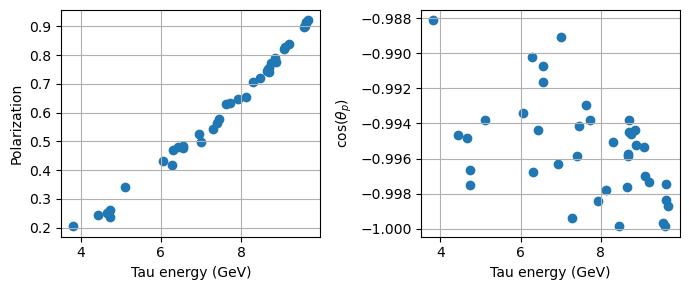

In [55]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = dis & cc & ((tau_angles * 180/np.pi) < 0.5)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "dis",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


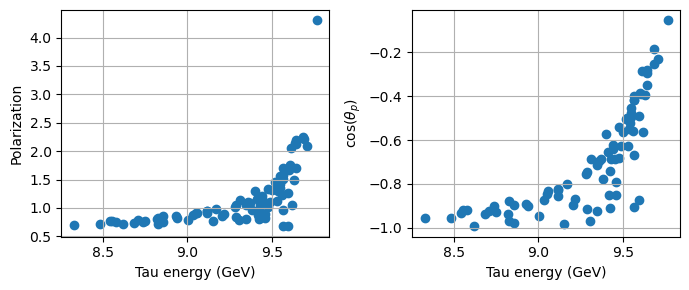

In [94]:
# If the collision is with a proton, the nucleon mass should be the proton mass
# If not, the nucleon mass should be the Oxygen mass / 16, since there are 16 nucleons in an Oxygen nucleus
nucleon4m = vector.array({"E": M, "px": np.zeros(len(M)), "py": np.zeros(len(M)), "pz": np.zeros(len(M))})
nutau4m = nutaus
tau4m = taus

q = nutau4m - tau4m
# Sanity checks
assert np.all((q**2) < 0)

tau_angles = np.arctan(np.sqrt(tau4m.px**2 + tau4m.py**2) / tau4m.pz)

zero_angle_tau_events = res & cc & ((tau_angles * 180/np.pi) < 1)

s = np.array(polarization_vector(
    tau4m[zero_angle_tau_events], 
    nutau4m[zero_angle_tau_events], 
    nucleon4m[zero_angle_tau_events], 
    "res",
    charm=(np.zeros(nutau4m[zero_angle_tau_events].shape[0], dtype=bool))
))
# Plot polarization vector norm and cos(theta_p) as a function of tau energy
fig, axs = plt.subplots(ncols=2, figsize=(7, 3), layout="tight")
axs[0].scatter(tau4m[zero_angle_tau_events].E, np.linalg.norm(s, axis=0))
axs[0].set(xlabel="Tau energy (GeV)", ylabel="Polarization")
axs[1].scatter(tau4m[zero_angle_tau_events].E, s[1] / np.linalg.norm(s, axis=0))
axs[1].set(xlabel="Tau energy (GeV)", ylabel=r"$\cos(\theta_p)$")

for ax in axs:
    ax.grid()


This plot looks just as weird. It is likely something wrong with the code.

In [260]:
event_info.loc[:, :"sea"]

,event_num,cc,dis,qel,res,nuel,coh,dfr,imd,xsec,diffxsec,hitnuc,hitqrk,sea
0,0,True,False,False,True,False,False,False,False,1.379589,1.309489,2112,0,False
1,1,True,True,False,False,False,False,False,False,10.824815,64.840946,2112,1,False
2,2,True,False,False,True,False,False,False,False,4.135627,0.047385,2212,0,False
3,3,True,True,False,False,False,False,False,False,10.824815,50.882509,2112,1,False
4,4,True,False,True,False,False,False,False,False,4.986601,0.168885,2112,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42488,42488,True,False,False,True,False,False,False,False,4.135627,5.167240,2212,0,False
42489,42489,True,True,False,False,False,False,False,False,10.824815,53.463345,2112,1,False
42490,42490,True,True,False,False,False,False,False,False,10.824815,56.063451,2112,1,False
42491,42491,True,True,False,False,False,False,False,False,10.824815,7.772559,2112,1,False


## Plot GRV98LO PDF

In [255]:
pdf = pd.read_csv("../data/crv98lo.csv")
bypdf = pd.read_csv("../data/bypdf.csv")

<Axes: xlabel='x', ylabel='PDF'>

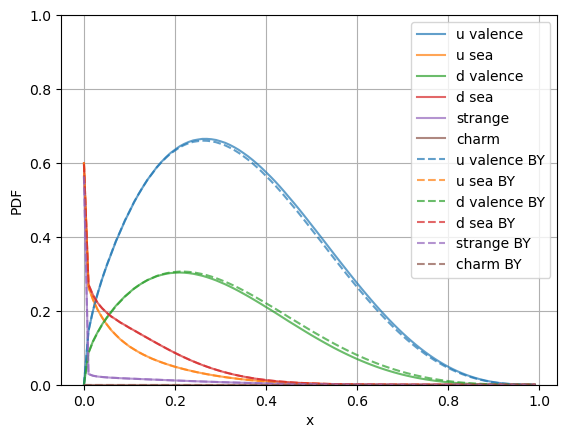

In [256]:
fig, ax = plt.subplots()

# Get the first 6 colors from the default line color sequence
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]

pdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], color=colors, ylim=(0, 1), label=["u valence", "u sea", "d valence", "d sea", "strange", "charm"], ylabel="PDF", grid=True, alpha=0.7, ax=ax)
bypdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], color=colors, ls="dashed", ylim=(0, 1), label=["u valence BY", "u sea BY", "d valence BY", "d sea BY", "strange BY", "charm BY"], ylabel="PDF", grid=True, alpha=0.7, ax=ax)

<Axes: xlabel='x', ylabel='x*PDF'>

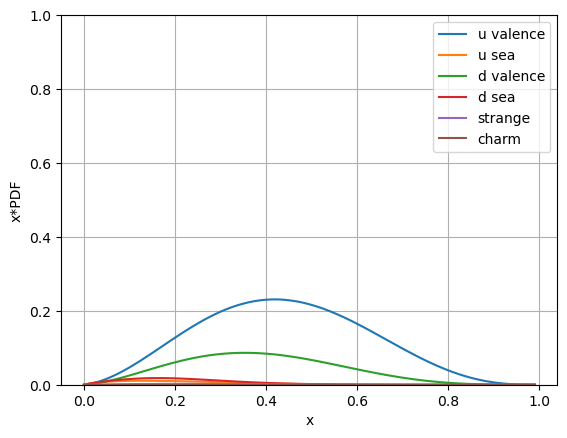

In [246]:
xpdf = pdf.copy()
xpdf[["fuv", "fus", "fdv", "fds", "fs", "fc"]] = xpdf[["fuv", "fus", "fdv", "fds", "fs", "fc"]] * xpdf["x"].values[:, np.newaxis]
xpdf.plot(x="x", y=["fuv", "fus", "fdv", "fds", "fs", "fc"], ylim=(0, 1), label=["u valence", "u sea", "d valence", "d sea", "strange", "charm"], grid=True, ylabel="x*PDF")